# Medical Expenditure Tutorial
This tutorial illustrates the use of the AIX360 toolkit to obtain directly interpretable models for predicting medical expenditure of individuals. The two algorithms considered are [Linear Rule Regression (LinRR)](#LinRR), which is a version of Generalized Linear Rule Models (GLRM) for predicting real-valued outcomes, and [Boolean Rule Column Generation (BRCG)](#BRCG). LinRR yields weighted combinations of AND rules that are accurate and have the interpretability of linear models and [generalized additive models](https://en.wikipedia.org/wiki/Generalized_additive_model). It is featured for the task of [expenditure prediction](#expenditure). BRCG gives very simple OR-of-ANDs classification rules and is featured for the task of [high-cost patient identification](#high-cost). The data used is taken from the [Medical Expenditure Panel Survey (MEPS)](https://meps.ahrq.gov/mepsweb/) and is processed as described in the [Data](#data) section.

1. [Use Case](#use-case)
2. [Data](#data)
3. [Expenditure prediction](#expenditure)
4. [High-cost patient identification](#high-cost)
5. [Conclusion](#conclusion)

<a name="use-case"></a>
## 1. Use Case
The task is to predict the annual healthcare expenditure of individuals based on demographic and socio-economic variables as well as self-reported medical conditions. These predictions are of interest to healthcare "payers," for example insurance companies, employers, governments, or individuals, who are financially responsible for the cost. The input data does not include actual healthcare experience (i.e. claims for services incurred), so the situation is similar to that of enrollment when an individual joins a healthcare plan.

Directly interpretable models have a sufficiently simple and transparent form to allow understanding of the behavior of the model as a whole, not just in specific instances (specific individuals). They can identify not only which features are most predictive of the output, but also the nature of the dependence (e.g. its direction and shape). This is most directly illustrated in the [Visualization](#visualize) section. For the present use case, these insights could be compared to a healthcare expert's domain knowledge and/or reviewed by managers before deploying the model, to increase confidence that it will perform as expected. Moreover, the insights could inform interventions to mitigate cost, for example as part of care management. While the models considered here are not causal models and the dependences identified are not necessarily causal, they could be interpreted causally with the help of expert knowledge, or they could suggest causal hypotheses to be tested in future studies.

<a name="data"></a>
## 2. Data
The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181), containing data from rounds 3, 4, 5 of panel 19 (2014) and rounds 1, 2, 3 of panel 20 (2015).

We use AIX360's `MEPSDataset` class to load and pre-process the data. The more notable steps in this processing are 1) restricting race to white and black and ethnicity to non-Hispanic, and 2) removing records with special values (negative integers) for some variables. The selected variables include demographics (e.g. age, gender, marital status), socio-economic factors (education, income, insurance coverage), self-reported health statuses, diagnoses (e.g. heart disease, stroke, diabetes), and health limitations (e.g. cognitive, activity, sensory).

In [1]:
# Load MEPS data
from aix360.datasets import MEPSDataset
data = MEPSDataset().data()

For this tutorial, we also drop the panel number (19 or 20, not meant to be predictive) and sample weights, and reset the row index to consecutive integers for simplicity.

In [2]:
# Reset index to consecutive integers
data.reset_index(drop=True, inplace=True)
# Drop panel number (not meant to be predictive) and sample weights
data.drop(columns = ['PANEL', 'PERSONWT'], inplace=True)
data.head()

,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,RTHLTH31,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,HEALTHEXP
0,2,52,0.0,0.0,5,13,-1,2,2,4,...,2,25.93,58.47,3,0,4,1,2,11390.0,46612
1,2,55,1.0,0.0,3,14,-1,2,2,4,...,2,20.42,26.57,17,6,4,3,2,11390.0,9207
2,2,22,1.0,0.0,5,13,3,2,2,1,...,2,53.12,50.33,7,0,1,2,2,18000.0,808
3,2,2,0.0,0.0,6,-1,-1,3,3,1,...,-1,-1.00,-1.00,-1,-1,-1,2,2,385.0,2721
4,3,25,1.0,0.0,1,14,-1,2,2,1,...,2,59.89,45.91,9,2,1,3,1,3700.0,1573


<a name="expenditure"></a>
## 3. Expenditure prediction

<a name="process-data"></a>
### 3.1. Process data for modelling
In this section, the task is to predict healthcare expenditure (HEALTHEXP). We separate the target variable from the data and split it into training and test sets.

In [3]:
# Separate target variable
y = data.pop('HEALTHEXP')
# Split data into training and test sets
from sklearn.model_selection import train_test_split
dfTrain, dfTest, yTrain, yTest = train_test_split(data, y, random_state=0)

The two algorithms LinRR and BRCG require non-binary features to be binarized using the provided `FeatureBinarizer` class. We list features that are to be considered as categorical, use the default of 9 quantile thresholds (i.e. 10 bins) to binarize ordinal (including continuous-valued) features, include all negations (e.g. '>' comparisons as well as '<='), and also return standardized versions of the original unbinarized ordinal features, which are used by LinRR but not BRCG.

In [4]:
# Categorical features
colCateg = ['REGION','MARRY31X','EDRECODE','FTSTU31X','ACTDTY31','HONRDC31',
            'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX',
            'EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX',
            'ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31',
            'COGLIM31','DFHEAR42','DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15']
# Binarize data and also return standardized ordinal features
from aix360.algorithms.rbm import FeatureBinarizer
fb = FeatureBinarizer(colCateg=colCateg, negations=True, returnOrd=True)
dfTrain, dfTrainStd = fb.fit_transform(dfTrain)
dfTest, dfTestStd = fb.transform(dfTest)

Below are the results of binarizing the REGION (US census region) and AGE31X features.

In [5]:
dfTrain['REGION'].head()

operation ==          !=         
value      1  2  3  4  1  2  3  4
1955       0  0  1  0  1  1  0  1
5122       0  1  0  0  1  0  1  1
16933      0  0  1  0  1  1  0  1
9837       0  1  0  0  1  0  1  1
2865       0  1  0  0  1  0  1  1

In [6]:
dfTrain['AGE31X'].head()

operation   <=                                            >                 \
value     7.0  14.0 23.0 31.0 38.0 47.0 54.0 61.0 70.0 7.0  14.0 23.0 31.0   
1955         0    0    0    0    0    0    1    1    1    1    1    1    1   
5122         0    0    0    0    1    1    1    1    1    1    1    1    1   
16933        1    1    1    1    1    1    1    1    1    0    0    0    0   
9837         0    0    0    0    1    1    1    1    1    1    1    1    1   
2865         0    1    1    1    1    1    1    1    1    1    0    0    0   

operation                           
value     38.0 47.0 54.0 61.0 70.0  
1955         1    1    0    0    0  
5122         0    0    0    0    0  
16933        0    0    0    0    0  
9837         0    0    0    0    0  
2865         0    0    0    0    0

<a name="baseline"></a>
### 3.2. Establish baseline
Predicting individual healthcare expenditure is inherently a difficult problem (particularly in the US healthcare system), especially given the limited input data considered here, which does not include past claims. The statistics of expenditure hint at this difficulty:

In [7]:
import numpy as np
y.describe(percentiles=np.linspace(0.1, 0.9, 9))

count     18350.000000
mean       5184.511608
std       15126.748532
min           0.000000
10%           0.000000
20%         114.000000
30.0%       302.000000
40%         585.000000
50%        1034.000000
60%        1784.800000
70%        3099.000000
80%        5619.800000
90%       12591.100000
max      659952.000000
Name: HEALTHEXP, dtype: float64

The distribution has a long and heavy tail consisting of high-cost individuals. This manifests itself in the mean being five times the median, the standard deviation being three times the mean, and the most costly individuals running into the hundreds of thousands of dollars.

Next we train and test a standard model, Gradient Boosted Regression Trees (GBRT), to establish a baseline. We use the same binarized/discretized data as [above](#process-data) to obtain a fair comparison. 

In [8]:
# Train and evaluate GBRT
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=500, random_state=0)
gbr.fit(dfTrain, yTrain)
from sklearn.metrics import r2_score
print('Training R^2:', r2_score(yTrain, gbr.predict(dfTrain)))
print('Test R^2:', r2_score(yTest, gbr.predict(dfTest)))

Training R^2: 0.5150817111907599
Test R^2: 0.14069941876567726


The test R^2 of 14.1% (100% means perfect prediction) confirms that the problem is difficult. (The training R^2 of 51.5% also suggests overfitting.)

<a name="LinRR"></a>
### 3.3. Run Linear Rule Regression (LinRR)
We now train and test a LinRR model. As seen below, LinRR produces a linear regression model that uses rule-based features. Here we are also including unbinarized ordinal features (`useOrd=True`) in addition to rules. The complexity parameters `lambda0`, `lambda1` penalize the number of rules included in the model and the number of conditions in each rule. The values for `lambda0`, `lambda1` below strike a good balance between accuracy and model complexity, based on our published experience with this MEPS dataset [[1]](http://proceedings.mlr.press/v97/wei19a.html). 

In [9]:
# Instantiate LinRR with good complexity penalties and numerical features
from aix360.algorithms.rbm import LinearRuleRegression
lrr = LinearRuleRegression(lambda0=0.03, lambda1=0.006, useOrd=True)
# Train and evaluate model
lrr.fit(dfTrain, yTrain, dfTrainStd)
print('Training R^2:', r2_score(yTrain, lrr.predict(dfTrain, dfTrainStd)))
print('Test R^2:', r2_score(yTest, lrr.predict(dfTest, dfTestStd)))

Training R^2: 0.16681096135277274
Test R^2: 0.1439870705684898


The test R-squared of 14.4% is slightly higher than that of GBRT. More importantly, the LinRR model is directly interpretable (provided that the feature names and values are explained, which we will do in the [Visualization](#visualize) section, see e.g. [[2]](https://meps.ahrq.gov/data_stats/download_data_files_codebook.jsp?PUFId=H181)[[3]](https://meps.ipums.org/meps/index.shtml) for more information on the features). The rule-based and ordinal features included in the linear regression model are shown below along with their coefficients. Being a linear model, feature importance is naturally given by the coefficients and thus the list is sorted in order of decreasing coefficient magnitude (note that coefficients can be positive or negative). The list can be truncated if the user wishes to display fewer features.

In [10]:
# Print model
lrr.explain()

,rule,coefficient
0,(intercept),13998.7
1,PCS42 <= -1.00,-8058
2,PCS42 <= 31.52,6827.75
3,RTHLTH31 != 5 AND PREGNT31 != 1,-6614.27
4,STRKDX == 1,4842.36
5,ADHDADDX != 1 AND PREGNT31 != 1 AND COGLIM31 !...,-3974.52
6,AGE31X,-3937.74
7,DIABDX == 1,3812.48
8,PREGNT31 != 1 AND ACTLIM31 != 1,-3778.59
9,CANCERDX == 1,3624.82


<a name="categories"></a>
The feature list above consists of:
1. unbinarized ordinal features (marked by just the feature name without conditions on its values, e.g. AGE31X),
2. rules with a single condition (e.g. PCS42 <= -1.00),  
3. rules with two or more conditions (e.g. RTHLTH31 != 5 AND PREGNT31 != 1). 

Features in categories 1 and 2 involve only one of the original unbinarized features (e.g. AGE31X, PCS42) at a time, while interactions between original features are all in category 3. Categories 1 and 2 therefore form a kind of [generalized additive model (GAM)](https://en.wikipedia.org/wiki/Generalized_additive_model), i.e. a sum of functions of individual features, where these functions are themselves sums of step function components from category 2 and linear components from category 1. A better visual summary of categories 1 and 2 can be obtained by plotting the univariate functions that make up the GAM, as we do next. We return to the interaction terms in category 3 in the [higher-degree rules](#higher-degree) section.

<a name="visualize"></a>
### 3.4. Visualize Generalized Additive Model (GAM) part of LinRR model
The `visualize()` method of LinRR is used to plot the GAM part of a LinRR model. To ease interpretation, we plot the component functions of the GAM in groups based on the semantics of the features. We can then examine the sizes and shapes of the dependences on individual features. These can be compared to a domain expert's knowledge to identify behaviors that are expected as well as those that may be surprising. We will attempt to provide such interpretation in this section, although we are not healthcare experts.

#### Health status summaries
The first three plots show the contributions of features that summarize an individual's health status. 

PCS42 stands for Physical Component Summary and measures physical health status over the four-week period before the MEPS survey date. It is a score computed from 12 responses that assigns higher weights to items such as limitations in activities, pain interfering with work, and difficulty climbing stairs. Lower values indicate poorer health. The plot shows corresponding increases in healthcare cost and especially high cost associated with values under 31.

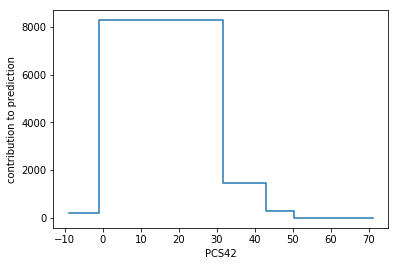

In [11]:
lrr.visualize(data, fb, ['PCS42']);

<a name="RTHLTH31"></a>
RTHLTH31 represents self-reported health status, with values 1-5 corresponding to "excellent," "very good," "good," "fair," and "poor." The algorithm has given non-zero coefficients only to "very good" and "fair," even though one might think that individuals in "excellent" health should see a reduction in cost at least as great as those in "very good" health. On the other hand, since the statuses are self-reported, "excellent" may not necessarily be better than "very good." The absence of a non-zero coefficient for "poor" health may be explained by its low frequency in the data. The non-smooth dependence on RTHLTH31 is due in part to treating RTHLTH31 as a categorical variable (see the definition of `colCateg` [above](#process-data)). If smoother behavior is desired, one may try treating values 1-5 of RTHLTH31 as an ordinal variable and handling the value RTHLTH31 == -1 ("inapplicable") separately.

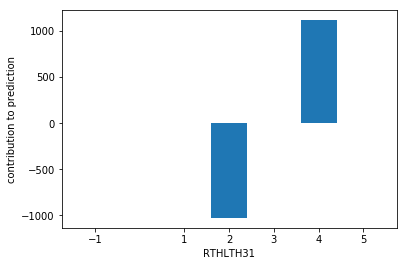

In [12]:
lrr.visualize(data, fb, ['RTHLTH31']);

K6SUM42 is a score known as the Kessler 6 Scale measuring non-specific psychological distress over the 30-day period prior to the survey. Higher values indicate higher stress and the LinRR algorithm finds a positive correlation with expenditure.

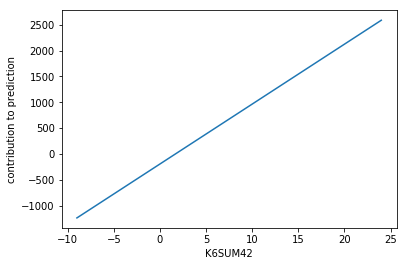

In [13]:
lrr.visualize(data, fb, ['K6SUM42']);

#### Medical diagnoses and conditions
The next 10 plots show the effects of having various medical diagnoses and conditions on the predicted cost. In order of importance and as shown below, these are diabetes, cancer, stroke, other heart disease, coronary heart disease, high blood pressure, joint pain in last 12 months, limitation in physical functioning (walking), arthritis, and type of arthritis. Except for WLKLIM31 and ARTHTYPE, a value of 1 means that the condition is present and contributes positively to the prediction as shown. A value of 2 means that the condition is absent, which in the case of WLKLIM31 contributes negatively. The increases in predicted cost due to these conditions (or decrease in the case of WLKLIM31) are all expected and the sizes of the coefficients indicate relative importance. Lastly, ARTHTYPE == -1 means "inapplicable", covering both those without arthritis as well as those under age 17 to whom the arthritis question is not applicable.

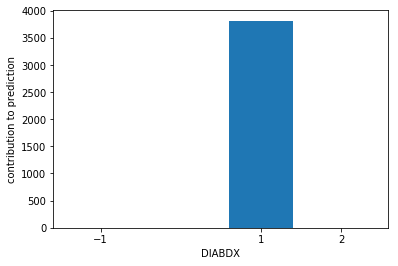

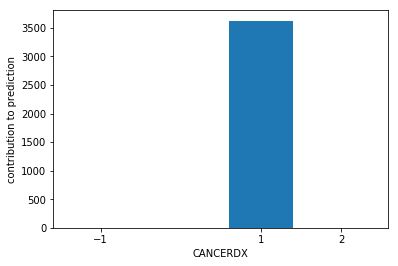

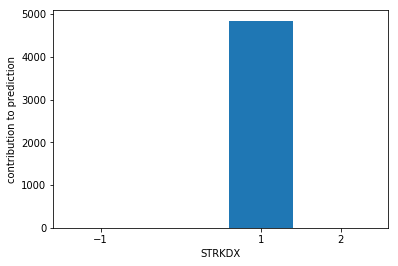

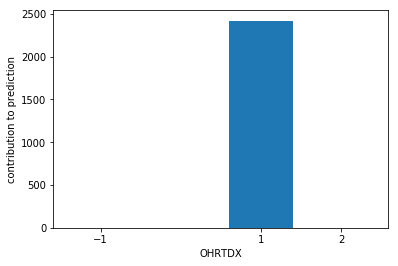

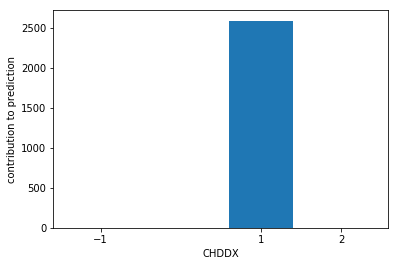

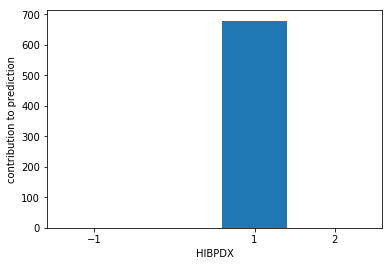

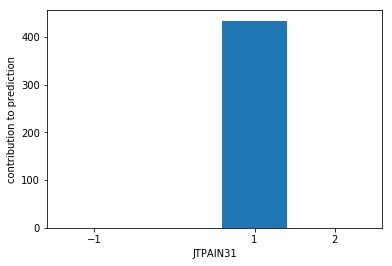

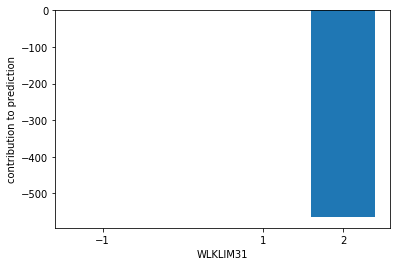

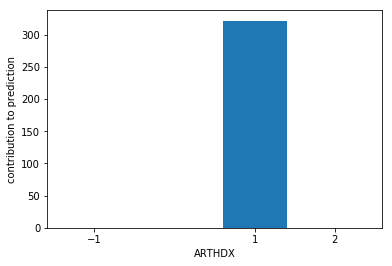

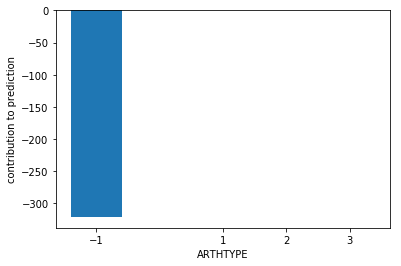

In [14]:
lrr.visualize(data, fb, ['DIABDX','CANCERDX','STRKDX','OHRTDX','CHDDX','HIBPDX','JTPAIN31','WLKLIM31','ARTHDX','ARTHTYPE']);

#### Current smoking status
The effect of current smoking status (ADSMOK42) is one example of a counter-intuitive finding that may warrant further investigation. A value of 2 indicates that the individual does not currently smoke, to which the model assigns a positive contribution to predicted cost. There may be confounding at work behind this association. For example, the average age of smokers (ADSMOK42 == 1) is 44 while the average age of non-smokers is 49, and older individuals are generally more costly. Furthermore, some individuals who currently do not smoke may have stopped due to poor health.

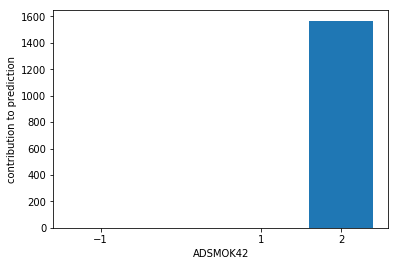

In [15]:
lrr.visualize(data, fb, ['ADSMOK42']);

#### Socio-economic factors
The following four plots examine the effects of socio-economic variables: income, insurance coverage, education, and employment status. 

The first plot shows that individuals with incomes less than $10,000 have lower cost while those with zero income have even lower cost. This is likely due to these individuals seeking less care because of inability to pay for their portion of the cost.

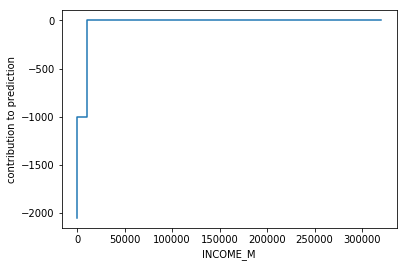

In [16]:
lrr.visualize(data, fb, ['INCOME_M']);

The second plot shows that individuals covered by any kind of private health insurance (INSCOV15 == 1) have higher costs. 

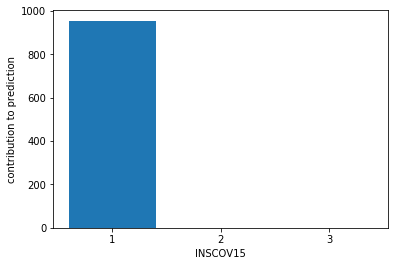

In [17]:
lrr.visualize(data, fb, ['INSCOV15']);

In the third plot, EDRECODE is a re-coded version of education. A value of 13 means high school graduate or GED, to which the model assigns a relatively small reduction in predicted cost. Values of 1 and 2 mean education less than a high school diploma, while values greater than 13 mean at least some college education.

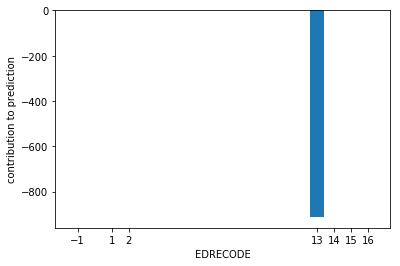

In [18]:
lrr.visualize(data, fb, ['EDRECODE']);

The last plot on employment status shows that the predicted cost for unemployed individuals (EMPST31 == 4) is slightly higher.

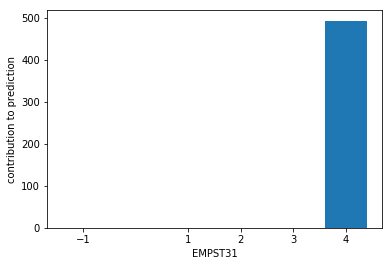

In [19]:
lrr.visualize(data, fb, ['EMPST31']);

#### Other demographic factors
The last four plots show the effects of other demographic variables such as age, race, and geography. 

The first plot with respect to age (in years) is non-smooth and points to a limitation of the LinRR model. Specifically, since the dependence on age is limited to a linear function (category 1 discussed [above](#categories)) plus step functions corresponding to threshold rules (category 2, not including interaction terms in category 3), the curve is constrained to be piecewise linear with all segments having the same slope and step discontinuities in between. The plot shows that predicted cost first decreases with age until the late 30s, roughly levels off in middle age, and then decreases further after the late 50s. While the first two stages of this behavior are reasonable, the last stage runs counter to the expectation that older individuals (say 60+) experience increasing healthcare costs. This unexpected dependence is mitigated by the second ACTDTY31 plot. While the ACTDTY31 feature is ostensibly about active military duty, a value of 4 actually means that the individual is over age 59 and the question is not applicable. ACTDTY31 == 4 is therefore a proxy for older age and does have a significant positive effect on cost. The non-smooth dependence on AGE31X may also be improved by allowing more general functions in the GAM, for example piecewise linear functions with arbitrary slopes.

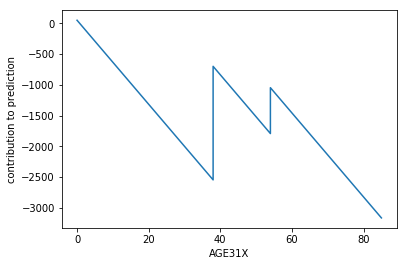

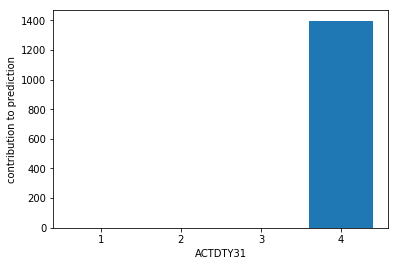

In [20]:
lrr.visualize(data, fb, ['AGE31X', 'ACTDTY31']);

The last two plots show that the predicted cost is lower for black individuals (RACE3 == 1) as well as residents in the South US Census region (REGION == 3).

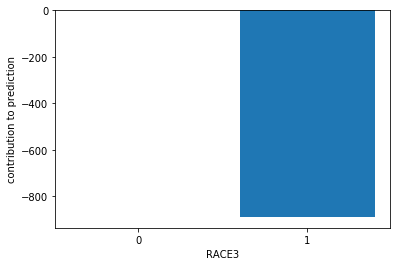

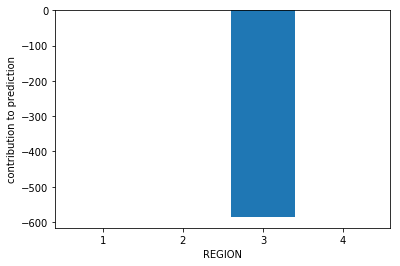

In [21]:
lrr.visualize(data, fb, ['RACE3', 'REGION']);

<a name="higher-degree"></a>
### 3.5. Examine higher-degree rules
Now that the linear terms (feature category 1 [above](#categories)) and first-degree rules (category 2) in the model have been summarized in the [Visualization](#visualize) section, we consider the higher-degree rules that remain (category 3). The `explain()` method of LinRR can print just the higher-degree rules:

In [22]:
import pandas as pd
pd.set_option('display.max_colwidth', 70)
pd.set_option('display.width', 100)
lrr.explain(highDegOnly=True)

,rule,coefficient
0,(intercept),13998.7
1,RTHLTH31 != 5 AND PREGNT31 != 1,-6614.27
2,ADHDADDX != 1 AND PREGNT31 != 1 AND COGLIM31 != 1 AND DFSEE42 != -1,-3974.52
3,PREGNT31 != 1 AND ACTLIM31 != 1,-3778.59
4,REGION != 1 AND DFSEE42 != -1,-2677.43
5,AGE31X > 7.00 AND MARRY31X != 8 AND MARRY31X != 10 AND PCS42 <= 50.22,2211.48
6,RTHLTH31 != 1 AND INSCOV15 != 3,1640.62
7,SOCLIM31 != -1 AND PHQ242 != 5 AND POVCAT15 != 5,-1565.76
8,PCS42 <= 53.99 AND INSCOV15 != 3,1277.63


These higher-degree rules are naturally more difficult to interpret and require more domain expertise to do so. The first three rules are perhaps the simplest. They yield large reductions in predicted cost when certain conditions are absent, with the common element being lack of pregnancy (PREGNT31 != 1). As noted [above](#RTHLTH31), RTHLTH31 != 5 means the individual is not in self-reported "poor" health, while ADHDADDX, COGLIM31, and ACTLIM31 refer respectively to attention-deficit/hyperactivity disorder, cognitive limitations, and any activity limitations at work, in housework, or at school. 

In rule 4, REGION != 1 indicates that the individual does not live in the Northeast census region, while DFSEE42 != -1 (also present in rule 2) indicates that the question about "serious difficulty seeing (even) with glasses" is not inapplicable. More cannot be said without knowing what makes the "serious difficulty seeing" question inapplicable. In rule 5, values of 8 and 10 for MARRY31X indicate that the individual was widowed or separated during the survey round. Again it is not clear why the absence of these conditions contributes to higher predicted cost, but the last condition PCS42 <= 50.22 does make sense as it corresponds to poor physical health.

In rules 6 and 8, INSCOV15 != 3 means that the individual has health insurance, whether public or private. Conditioned on this, self-reported health that is less than "excellent" (RTHLTH31 != 1) and poorer physical health (PCS42 <= 53.99) result in higher predicted cost. Lastly in rule 7, PHQ242 is a score for depression with higher values corresponding to greater tendency toward depression. PHQ242 != 5 thus indicates the absence of a high value, although not the highest value of 6. POVCAT15 != 5 means that the individual does not have high income (400% above the poverty level) while SOCLIM != -1 means that the question about social limitations is applicable.

<a name="high-cost"></a>
## 4. High-cost patient identification
To demonstrate the Boolean Rule Column Generation (BRCG) algorithm, we require a binary classification task since that is what BRCG is designed for. Here we consider the identification of high-cost individuals, which is of interest for the care management use case. We define high cost as being above the mean (which is already high relative to the median) and create a binary-valued target variable accordingly. The input features are the same as used to predict expenditure.

In [23]:
# Binarize target variable
y2 = (y > y.mean()).astype(int)
y2.mean()

0.21493188010899184

Only 21.5% of individuals have costs greater than the mean, which is consistent with the mean being close to the 80th percentile of expenditure as seen [earlier](#baseline).

### 4.1. Re-process data
We re-split the data into training and test sets, this time stratifying on the target variable. The features are then binarized as before.

In [24]:
# Re-split data into training and test sets
dfTrain, dfTest, yTrain, yTest = train_test_split(data, y2, random_state=0, stratify=y2)
# Binarize data
dfTrain, _ = fb.fit_transform(dfTrain)
dfTest, _ = fb.transform(dfTest)

### 4.2. Establish baseline
We again use gradient-boosted trees to establish a baseline for accuracy, specifically the classification variant (GBCT).

In [25]:
# Train and evaluate GBCT
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=500)
gbc.fit(dfTrain, yTrain)
from sklearn.metrics import accuracy_score
print('Training accuracy:', accuracy_score(yTrain, gbc.predict(dfTrain)))
print('Test accuracy:', accuracy_score(yTest, gbc.predict(dfTest)))

Training accuracy: 0.8705856706874001
Test accuracy: 0.8304272013949433


<a name="BRCG"></a>
### 4.3. Run Boolean Rule Column Generation (BRCG) and interpret rules
Now we use BRCG to perform the same classification task. BRCG produces a very simple set of rules (also known as an OR-of-ANDs or disjunctive normal form (DNF) rule) for predicting that an individual is high-cost. AIX360 implements a heuristic beam search version of BRCG that is less computationally intensive than the published integer programming version [[4]](http://papers.nips.cc/paper/7716-boolean-decision-rules-via-column-generation). Similar to LinRR, the complexity parameters `lambda0`, `lambda1` penalize the number of rules in the rule set and the number of conditions in each rule. The values of `lambda0`, `lambda1` below provide a good trade-off between accuracy and rule set complexity. Lower values were observed to yield more complex rules but with no improvement in accuracy.

In [26]:
# Instantiate BRCG
from aix360.algorithms.rbm import BooleanRuleCG
br = BooleanRuleCG(lambda0=1e-4, lambda1=1e-4)
# Train, print, and evaluate model
br.fit(dfTrain, yTrain)
print('Training accuracy:', accuracy_score(yTrain, br.predict(dfTrain)))
print('Test accuracy:', accuracy_score(yTest, br.predict(dfTest)))
print('Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:')
print(br.explain()['rules'])

Learning DNF rule with complexity parameters lambda0=0.0001, lambda1=0.0001
Initial LP solved
Iteration: 1, Objective: 0.1903
Iteration: 2, Objective: 0.1858
Iteration: 3, Objective: 0.1858
Iteration: 4, Objective: 0.1844
Iteration: 5, Objective: 0.1830
Iteration: 6, Objective: 0.1823
Iteration: 7, Objective: 0.1820
Iteration: 8, Objective: 0.1815
Iteration: 9, Objective: 0.1815
Iteration: 10, Objective: 0.1814
Iteration: 11, Objective: 0.1814
Training accuracy: 0.8129632320883593
Test accuracy: 0.8092850915431561
Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:
['EDRECODE == 15 AND ACTLIM31 == 1', 'ARTHTYPE != -1 AND WLKLIM31 != 2 AND PCS42 <= 50.22 AND INSCOV15 != 3']


In this case, the test accuracy is lower than that of GBCT. The advantage of the BRCG model is its simplicity: It identifies two readily understood subgroups of individuals (not mutually exclusive) predicted to have high cost. The first subgroup consists of individuals with bachelor's degrees (EDRECODE == 15) who have activity limitations affecting work, housework, or school (ACTLIM31 == 1). The second subgroup has limitations in physical functioning (walking, WLKLIM31 != 2), lower physical health status (PCS42 <= 50.22), and some health insurance coverage (INSCOV15 != 3). The first condition, ARTHTYPE != -1, indicates that the question about arthritis type is not inapplicable, which presumably means that the individual does have arthritis and is also 18 years of age or older. One might infer that the common thread between the two subgroups is some sort of physical limitation or poor health coupled with a proxy for higher income (bachelor's degree) or ability to pay (insurance coverage).

<a name="conclusion"></a>
## 5. Conclusion
This tutorial has shown that the directly interpretable supervised learning algorithms included in AIX360, Generalized Linear Rule Models (GLRM) and Boolean Rule Column Generation (BRCG), are capable of producing accurate and interpretable models for predicting healthcare expenditure. In the case of GLRM (specifically the Linear Rule Regression version), the accuracy is higher than an uninterpretable gradient boosting benchmark while retaining the form of a linear model, the interpretation of which is enhanced by plotting the generalized additive model (GAM) part of the overall model. In the case of BRCG, the accuracy is lower but the model consists of just two rules that are readily understood. We believe that such directly interpretable predictive models (not reliant on post-hoc explanations of individual cases) can be particularly helpful in human-machine collaborations with domain experts and downstream decision-makers.